In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import imageio
from imageio import imread, imsave, mimsave
from tensorflow.keras import layers
import os

In [2]:
print(tf.__version__)

2.3.0


In [3]:
weight_init_std = 0.02
weight_init_mean = 0.0
weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=weight_init_std, mean=weight_init_mean,
                                                          seed=42)
lr_initial_d = tf.Variable(0.0002)
lr_initial_g = tf.Variable(0.0002)
lr_decay_steps = 1000
decay_step = 50
noise_dim = 128
dropout_rate = 0.5

In [4]:
weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=weight_init_std, mean=weight_init_mean,
                                                          seed=42)

In [5]:
generator_optimizer = tf.optimizers.Adam(learning_rate=lr_initial_g, beta_1=0.5)

In [6]:
discriminator_optimizer = tf.optimizers.Adam(learning_rate=lr_initial_d, beta_1=0.5)

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1),  padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),  padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),  padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(32, (5,5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Dense(3, activation='tanh', kernel_initializer=weight_initializer))
    print("GENERATOR")
    model.summary()
    return model

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()   
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))   
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(128, (5,5), 
                             strides=(2,2),
                             padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(256, (5,5), 
                             strides=(2,2),
                             padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(512, (5,5), 
                             strides=(2,2),
                             padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    print("DISCRIMINATOR")
    model.summary()
    
    return model

In [9]:
generator = make_generator_model()
print(generator.summary())

GENERATOR
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             4194304   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
re_lu (ReLU)                 (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)

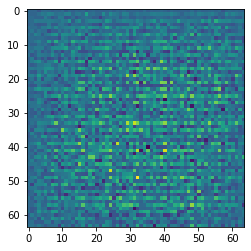

In [10]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise,training=False)
plt.imshow(generated_image[0, :, :, 0])

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

DISCRIMINATOR
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4

In [12]:
generator_optimizer = tf.optimizers.Adam(learning_rate=lr_initial_g, beta_1=0.5)
discriminator_optimizer = tf.optimizers.Adam(learning_rate=lr_initial_d, beta_1=0.5)

In [13]:
def generate_test_image(model, noise_dim=noise_dim):
    test_input = tf.random.normal([1, noise_dim])
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(5,5))
    plt.imshow((predictions[0, :, :, :] * 127.5 + 127.5) / 255.)
    plt.axis('off') 
    plt.show()

In [14]:
def generate_and_show_images(dog_generator, rows=4, cols=4):
    #predictions = np.asarray([dog_generator(tf.random.normal([1, noise_dim]))[0] for i in range(16)], dtype=np.float32)
    predictions = dog_generator(tf.random.normal([16, noise_dim]))
    print(predictions.shape)
    fig = plt.figure(figsize=(9,9))
    for i in range(predictions.shape[0]):
        plt.subplot(rows, cols, i+1)
        plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5) / 255.)
        plt.axis('off') 
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [16]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

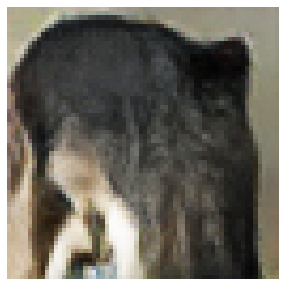

In [18]:
generate_test_image(generator)

(16, 64, 64, 3)


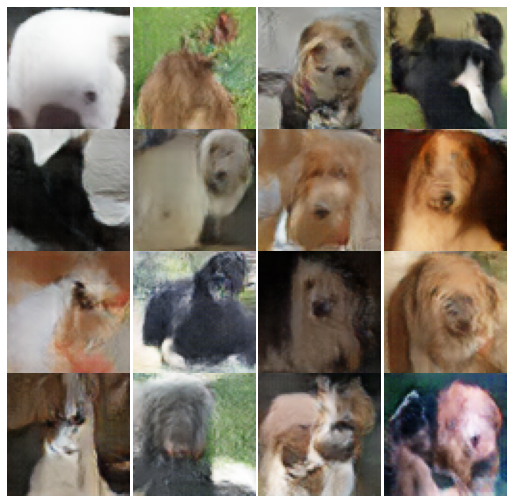

In [19]:
generate_and_show_images(generator)